# 💣 gRNAde 101

<a target="_blank" href="https://colab.research.google.com/drive/16rXKgbGXBBsHvS_2V84WbfKsJYf9lO4Q">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

Computational RNA design tasks are often posed as inverse problems, where sequences are designed based on adopting a single desired secondary structure without considering 3D geometry and conformational diversity.
In this tutorial, we present **gRNAde**, a **g**eometric **RNA** **de**sign pipeline operating on sets of 3D RNA backbone structures to design sequences that explicitly account for RNA 3D structure and dynamics.
gRNAde is a Graph Neural Network that uses an SE(3) equivariant encoder-decoder framework for generating RNA sequences conditioned on backbone structures where the identities of the bases are unknown.
We demonstrate the utility of gRNAde for fixed backbone re-design of existing RNA structures of interest from the PDB, including riboswitches, aptamers, and ribozymes.

![](fig/grnade_pipeline.png)

---

## Introduction

<details>
<summary><b>Why RNA design?</b></summary>

Historical efforts in computational drug discovery have focussed on designing small molecule or protein-based medicines that either treat symptoms or counter the end stages of disease processes. In recent years, there is a growing interest in designing new RNA-based therapeutics that intervene earlier in disease processes to cut off disease-causing information flow in the cell [1]. Notable examples of RNA molecules at the forefront of biotechnology today include mRNA vaccines [2], CRISPR-based genomic medicine [3], and riboswitch biosensors [4].

</details>

<details>
<summary><b>Challenges of RNA modelling</b></summary>

Despite the promises of RNA, proteins have instead been the primary focus in the artificial intelligence and 3D biomolecular modelling community. 
Availability of a large amount protein structural data from the PDB combined with advances in geometric deep learning for structured data [5] have revolutionized protein 3D structure prediction [6] and design [7, 8].
Applications of deep learning for computational RNA design are underexplored compared to proteins due to paucity of 3D structural data [9, 10].
Most tools for RNA design primarily focus on secondary structure without considering 3D geometry [11] or use non-learnt algorithms for aligning 3D RNA motifs [12].
In addition to limited 3D data for training deep learning models, the key technical challenge is that RNA is more dynamic than proteins.
The same RNA can adopt multiple distinct conformational states to create and regulate complex biological functions [13, 14, 15].
Computational RNA design pipelines must account for both the 3D geometric structure and conformational flexibility of RNA to engineer new biological functions.

</details>

**What is gRNAde?**

gRNAde aims to be a modern, deep learning-based toolkit for RNA sequence design conditioned on 3D structure, analogous to [ProteinMPNN](https://github.com/dauparas/ProteinMPNN) for protein design.
gRNAde generates candidate RNA sequences conditioned on one or more backbone 3D conformations, enabling both single- and multi-state fixed-backbone sequence design.
The model is trained on all RNA structures from the PDB at 4.0A or better resolution (12K 3D structures from 4.2K unique RNAs) [16], ranging from short RNAs such as riboswitches, aptamers and ribozymes to larger ribosomal RNAs.

We will show how to use gRNAde for two RNA inverse design tasks:
1. Fixed backbone redesign of an RNA backbone, ie. single-state design.
2. Fixed backbone redesign of an ensemble of RNA backbones, ie. multi-state design.

We will also compare gRNAde to Rosetta [17], an existing physics-based tools for 3D RNA inverse design, for single-state fixed backbone design of 14 RNA structures of interest from the PDB identified by Das et al. [18].
We obtain higher native sequence recovery rates with gRNAde (56% on average) compared to Rosetta (45% on average), while expecting gRNAde to be significantly faster (order of seconds compared to order of hours for Rosetta).

---

## Background and Methodology

<details>
<summary><b>Installation</b></summary>

### Installation

gRNAde is available as a free and open-source software at `https://github.com/chaitjo/geometric-rna-design`, along with detailed setup and usage instructions.
We have tested gRNAde on Linux with Python 3.10.12 and CUDA 11.8 on NVIDIA A100 80GB GPUs and Intel XPUs, as well as on MacOS (CPU).

1. Clone or download files from the GitHub repository:
```
git clone https://github.com/chaitjo/geometric-rna-design.git; cd geometric-rna-design
```

2. Follow the installation instructions in the README file to set up your python environment and install all dependencies (PyTorch, PyTorch Geometric) and external tools (EternaFold, X3DNA).

3. Set up your `.env` file with the appropriate environment variables; see `.env.example` for reference. Alternatively, export environment variables pointing to EternaFold and X3DNA directories; for example:
```
export PROJECT_PATH='/home/ckj24/geometric-rna-design/'
export ETERNAFOLD='/home/ckj24/geometric-rna-design/tools/EternaFold'
export X3DNA='/home/ckj24/geometric-rna-design/tools/x3dna-v2.4'
export PATH="/home/ckj24/geometric-rna-design/tools/x3dna-v2.4/bin:$PATH"
```

4. Ensure that your new python environment for gRNAde is active.

</details>

<details>
<summary><b>Input Data Format and Preparation</b></summary>

### Input Data Format and Preparation

The input format for gRNAde is via PDB files of RNA structures. Internally, gRNAde builds a 3-bead coarse-grained representation of the RNA backbone, retaining the coordinates for P, C4', N1 (pyrimidine) or N9 (purine) for each nucleotide [19]. This 3-bead pseudotorsional representation can describe RNA backbone conformations completely in most cases while reducing the size of the backbone torsional space to prevent overfitting [20].

The `RNAGraphFeaturizer` module in `src/data/featurizer.py` can be used to process a PDB file containing a single RNA chain into a featurized geometric graph in PyTorch Geometric's `torch_geometric.data.Data` format:
1. Each nucleotide is assigned a node in the geometric graph with the 3D coordinate corresponding to the centroid of the 3 bead atoms.
2. Each node is connected by edges to its 32 nearest neighbours as measured by the distance between them.
3. Node features include unit vectors, distances, angles, and torsions along the backbone from the 5' end to the 3' end, as well as unit vectors, distances, angles, and torsions from each C4' to the corresponding P and N1/N9.
4. Edge features include unit vectors from the source to destination node, the distance encoded by 32 radial basis functions, and the distance along the backbone encoded by 32 sinusoidal positional encodings.

![](fig/backbone_featurizer.png)

</details>

<details>
<summary><b>gRNAde Model Architecture</b></summary>

### gRNAde Model Architecture

The `gRNAde` module in `gRNAde.py` takes as input one or more PDB files corresponding to an RNA structure and featurizes them into a geometric graph as described in the previous section, with the identities of the nucleotide bases kept unknown.
An instance of `RNAGraphFeaturizer` is internally instantiated within a gRNAde to do so.

gRNAde then processes the featurized geometric graph using the `AutoregressiveMultiGNNv1` module from `src/models.py` as follows:
1. The geometric graph is encoded via an SE(3) equivariant and conformer order equivariant Graph Neural Network [21, 22] to build latent representations of the local 3D geometric neighbourhood of each nucleotide.
2. Latent representations from multiple states at each nucleotide position are then pooled together via Deep Sets [23] to account for conformational variability, and decoded to predict a probability distribution over the four possible base identities (A, G, C, U).
4. The probability distribution can then be sampled to design a set of candidate sequences for a single structure (single-state design) or a conformational ensemble (multi-state design).

During training, the entire model is trained end-to-end by minimising a cross-entropy loss between the predicted probability distribution and the true sequence identity, as detailed in the `train()` function in `src/trainer.py`.

![](fig/grnade_model.png)

</details>

<details>
<summary><b>Evaluation</b></summary>

### Evaluation Metrics

Once we have obtained a set of designed sequences, how do we determine which sequences are useful and which ones to prioritise? Short of wet lab experimentation, the following in-silico metrics can be used to evaluate gRNAde's designs:

1. **Native sequence recovery**, which is the average percentage of native (groundtruth) nucleotides correctly recovered in 16 sampled sequences. This is the most widely used metric for biomolecule inverse design [7].

2. **Secondary structure self-consistency score**, where we 'forward fold' 16 sampled sequences using a secondary structure prediction tool (we used EternaFold) and measure the average Mathew's Correlation Coefficient (MCC) to the groundtruth secondary structure. MCC values range between -1 and +1, with +1 represents a perfect prediction, 0 an average random prediction and -1 an inverse prediction. Similar forward folding metrics, sometimes termed 'designability', have been found to correlate with experimental success in 3D protein design [8]. Beyond this tutorial, our codebase also provides methods to use 3D structural self-consistency scores with RhoFold as the structure prediction model.

3. **Perplexity**, which is the average exponential of the negative log-likelihood of 16 predicted sequences and can be thought of as the average number of bases that the model is selecting from for each nucleotide. A perfect model would have perplexity of 1, while a perplexity of 4 means that the model is making random predictions (the model outputs a probability over 4 possible bases). Perplexity does not require a groundtruth structure to calculate, and can also be used for ranking sequences based on the model's estimate of their compatibility with the structure to be designed.

The evaluation metrics are computed every time we use the `design()` function for the `gRNAde` module (described in detail subsequently), or via the `evaluate()` function in `src/trainer.py`.

![](fig/evaluation.png)

</details>

In [1]:
# Import libraries and set up the environment

import sys
sys.path.append('../')

import dotenv
dotenv.load_dotenv("../.env")

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from src.constants import PROJECT_PATH

## Example Usage

### Instantiating the gRNAde module

The `gRNAde` module in `grnade.py` provides a simple interface for fixed-backbone re-design of 3D RNA structures for both the single and multi-state setting.
An instance of the gRNAde module can be created as follows by providing:
1. `split`, the training dataset split used for training gRNAde (for now, we will use the `das` split which we will describe subsequently).
2. `max_num_conformers`, the maximum number of conformational states that one wishes to consider as input for the design task at hand (by default `1`, at most `5`); 
3. `gpu_id`, the GPU ID on which the model will be run (defaults to CPU if no GPUs are available).

Under the hood, gRNAde automatically loads the model checkpoint corresponding to the number of conformational states selected.

In [2]:
# Import the gRNAde module
from gRNAde import gRNAde

# Create an instance of gRNAde
gRNAde_module = gRNAde(split='das', max_num_conformers=1, gpu_id=0)

Instantiating gRNAde v0.3
    Using device: cuda:0
    Creating RNA graph featurizer for max_num_conformers=1
    Initialising GNN encoder-decoder model
    Loading model checkpoint: /home/ckj24/rna-inverse-folding/checkpoints/gRNAde_ARv1_1state_das.h5
Finished initialising gRNAde v0.3



---

### Single-state inverse folding

The `design_from_pdb_file()` function in the gRNAde module performs fixed-backbone re-design of a single RNA structure from a PDB file and optionally saves the designed sequences to a fasta file.
The workflow is as follows:

1. Prepare a PDB file for fixed-backbone re-design. For instance, we will use a [guanine riboswitch](https://proteopedia.org/wiki/index.php/Guanine_riboswitch) aptamer domain (PDB ID: [4FE5](https://www.rcsb.org/structure/4FE5)) for which the filepath is `/tutorial/demo_data/4FE5_1_B.pdb`. Note that the PDB file must contain only one chain and all RNA backbone atoms.

2. Specify an output filepath pointing to a fasta file where the designed sequences, corresponding evaluation metrics, and additional metadata will be saved. We will set this to `/tutorial/demo_output.fasta`.

3. Set the following configurations for the model's sampling process:
    - `n_samples`, the number of samples which are designed by gRNAde for the input RNA structure.
    - `temperature`, which is used to modulate the smoothness or sharpness of the probability distribution produced by the model. At lower temperatures, for instance <= 1, we expect to have higher native sequence recovery and lower diversity in the model's designs. At higher temperatures, the model produces more diverse designs by sampling from a smoothed probability distribution.
    We recommend sampling at temperatures in the range 0.1 - 0.5 for the best results.
    - `seed`, the random seed for obtaining reproducible results. 

4. Call the `design_from_pdb_file()` function from the `grnade_module` instance using the specified input and output filepaths as well as sampling configurations.

5. Within seconds, the designed sequences will be saved to the fasta file `/tutorial/demo_output.fasta`.

<details>
<summary><b>Understanding the output</b></summary>

The contents of the output fasta file can be understood as follows:

1. The first entry is the native sequence from the input PDB file. The description contains metadata about the gRNAde model, such as the version, model type, maximum number of conformers, checkpoint filepath, and random seed used for the design.

2. Each subsequent entry contains a designed sequence. The description includes the sample number, the temperature of sampling, and evaluation metrics such as perplexity, native sequence recovery, and secondary structure self-consistency score.

3. We see that gRNAde produces designs within a range of approximately 0.4 - 0.6 native sequence recovery rate, with self-consistency scores between 0.3 - 0.9. It is interesting to note that a lower sequence recovery does not automatically imply a lower self-consistency score, and vice-versa.

</details>

<details>
<summary><b>Running via the command line</b></summary>

Alternatively to the workflow described above, we can also use the `gRNAde.py` script via command line arguments to achieve the same outcome, as follows:
```sh
python gRNAde.py \
    --pdb_filepath tutorial/demo_data/4FE5_1_B.pdb \
    --output_filepath tutorial/demo_output.fasta \
    --split das \
    --max_num_conformers 1 \
    --n_samples 16 \
    --temperature 0.5
```

</details>

In [3]:
# Single-state design example usage
sequences, samples, perplexity, recovery_sample, sc_score = gRNAde_module.design_from_pdb_file(
    pdb_filepath = os.path.join(PROJECT_PATH, "tutorial/demo_data/4FE5_1_B.pdb"),
    output_filepath = os.path.join(PROJECT_PATH, "tutorial/outputs/demo_output.fasta"),
    n_samples = 16,
    temperature = 1.0,
    seed = 0
)
for seq in sequences:
    print(seq.format('fasta'))

>input_sequence, gRNAde_version=0.3, model=AutoregressiveMultiGNNv1, max_num_conformers=1, checkpoint=/home/ckj24/rna-inverse-folding/checkpoints/gRNAde_ARv1_1state_das.h5, seed=0
GGACAUAUAAUCGCGUGGAUAUGGCACGCAAGUUUCUACCGGGCACCGUAAAUGUCCGAC
UAUGUCC

>sample=0, seed=0, temperature=1.0, perplexity=1.9213, recovery=0.5606, edit_dist=29, sc_score=0.6665
GACAAGUAAUCCCCGCGCUAGGGGCGGGGACUUACAAGUUUGCCCGUUAAAGGUAAAGCU
CUGUCC

>sample=1, seed=0, temperature=1.0, perplexity=1.5930, recovery=0.5000, edit_dist=26, sc_score=0.8497
ACAUAGUAAUCCCCUCGCUAGGGGAGGGGAGGUCCAGCUGUGUCCCGUAAAGAUACGACC
UAUGUU

>sample=2, seed=0, temperature=1.0, perplexity=1.7012, recovery=0.4242, edit_dist=36, sc_score=0.9227
GGGAUGUAAGUCCAACGUUAAGGGUUGGACAUCCCAUUAUUGUCCCUUUAAGAUAAUACC
AUCCCG

>sample=3, seed=0, temperature=1.0, perplexity=2.2303, recovery=0.3939, edit_dist=33, sc_score=0.8080
GGGAUGUAACUCUUCUGCUACGCAGAAGAGGUUACGGCACAGUCGAGUGAAGAUUGUCCC
AUCCCU

>sample=4, seed=0, temperature=1.0, perplexity=2.0344, recovery=0.

---

### Comparing gRNAde to physics-based RNA inverse folding

Rosetta is a state-of-the-art physics-based toolkit for biomolecular modelling and design [17].
We can use gRNAde's `design_from_pdb_file` function to compare it to Rosetta's [fixed backbone RNA sequence design](https://www.rosettacommons.org/docs/latest/application_documentation/rna/rna-design) workflow.
We use gRNAde to re-design 14 RNA structures of interest from the PDB identified by Das et al. [18], which mainly includes riboswitches, aptamers, and ribozymes.
These structures are available at the directory `/tutorial/demo_data/`.

In [8]:
# Metadata and recoveries from Das et al.

demo_data_id = ["1CSL","1ET4","1F27","1L2X","1LNT","1Q9A","4FE5","1X9C","1XPE","2GCS","2GDI","2OEU","2R8S","354D",]

demo_data_info = [
    "RRE high affinity site",
    "Vitamin B12 binding RNA aptamer",
    "Biotin-binding RNA pseudoknot",
    "Viral RNA pseudoknot",
    "RNA internal loop of SRP",
    "Sarcin/ricin domain from E.coli 23S rRNA",
    "Guanine riboswitch aptamer",
    "All-RNA hairpin ribozyme",
    "HIV-1 B RNA dimerization initiation site",
    "Pre-cleavage state of glmS ribozyme",
    "Thiamine pyrophosphate-specific riboswitch",
    "Junctionless hairpin ribozyme",
    "Tetrahymena ribozyme P4-P6 domain",
    "Loop E from E. coli 5S rRNA",
]

vienna_recovery = [0.2566288,0.25852272,0.2951389,0.2448347,0.325,0.27455357,0.2916667,0.26201922,0.2709652,0.24888393,0.25,0.23317307,0.26923078,0.28035715]

farna_recovery = [0.20,0.34,0.36,0.45,0.27,0.40,0.28,0.31,0.24,0.26,0.38,0.30,0.36,0.35,]

rosetta_recovery = [0.44,0.44,0.37,0.48,0.53,0.41,0.36,0.50,0.40,0.44,0.48,0.37,0.53,0.55,]

# Evaluate gRNAde on the Das et al. data
grnade_recovery = []
grnade_perplexity = []
grnade_sc_score = []
for pdb_filepath in os.listdir(os.path.join(PROJECT_PATH, "tutorial/demo_data/")):
    if pdb_filepath.endswith(".pdb"):
        sequences, samples, perplexity, recovery_sample, sc_score = gRNAde_module.design_from_pdb_file(
            pdb_filepath=os.path.join(PROJECT_PATH, f"tutorial/demo_data/{pdb_filepath}"),
            n_samples=16,
            temperature=0.1,
            seed=0
        )
        grnade_recovery.append(np.mean(recovery_sample))
        grnade_perplexity.append(np.mean(perplexity))
        grnade_sc_score.append(np.mean(sc_score))

# Collate results as dataframes for plotting
df = pd.DataFrame.from_dict({
    "idx": list(range(len(farna_recovery))),
    "pdb_id": demo_data_id,
    "description": demo_data_info,
    "vienna_recovery": np.array(vienna_recovery),
    "farna_recovery": np.array(farna_recovery),
    "rosetta_recovery": np.array(rosetta_recovery),
    "grnade_recovery": np.array(grnade_recovery),
    "grnade_perplexity": np.array(grnade_perplexity),
    "grnade_sc_score": np.array(grnade_sc_score),
})
df_sample = pd.DataFrame.from_dict({
    "idx": list(range(len(farna_recovery) * 4)),
    "mean_recovery": np.array(vienna_recovery + farna_recovery + rosetta_recovery + grnade_recovery),
    "model_name": ["ViennaRNA\n(2D only)"] * len(vienna_recovery) + ["FARNA"] * len(farna_recovery) + ["Rosetta"] * len(rosetta_recovery) + ["gRNAde"] * len(grnade_recovery),
})
df.to_csv(os.path.join(PROJECT_PATH, "tutorial/outputs/benchmark.csv"))

# Print mean recovery model
print(df_sample.groupby("model_name").mean())
# print(df_sample.groupby("model_name").median())

                       idx  mean_recovery
model_name                               
FARNA                 20.5       0.321429
Rosetta               34.5       0.450000
ViennaRNA\n(2D only)   6.5       0.268641
gRNAde                48.5       0.568228


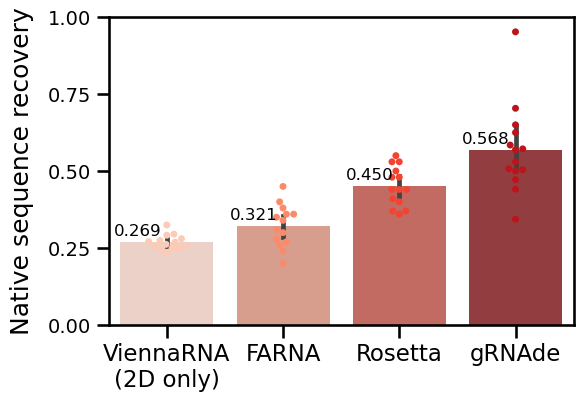

In [10]:
# Plot the results
sns.set_context("talk")
plt.figure(figsize=(6, 4))

sns.swarmplot(
    data = df_sample,
    x="model_name", y="mean_recovery",
    hue="model_name", palette="Reds",
)

ax = sns.barplot(
    data = df_sample,
    x="model_name", y="mean_recovery",
    hue="model_name", saturation=0.5, palette="Reds",
)
# Add labels to each bar
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.3f'), 
                 (p.get_x() + p.get_width() / 2., p.get_height()), 
                 ha = 'right', va = 'center', 
                 xytext = (-4, 8), 
                 textcoords = 'offset points',
                 fontsize=12)

# ax.grid(True, which='both', linestyle='--', linewidth=0.5, color='gray')
# ax.bar_label(ax.containers[0], fontsize=10)
plt.xlabel("")
plt.ylabel("Native sequence recovery", labelpad=10)
# plt.ylim(0, 1)
plt.yticks(np.arange(0, 1.01, 0.25), fontsize=14)
plt.savefig(os.path.join(PROJECT_PATH, "tutorial/outputs/singlestate-barplot.pdf"), dpi=300, bbox_inches="tight")
plt.show()

When comparing gRNAde to the native sequence recovery rates for Rosetta and the older FARNA technique (we took the numbers from Das et al. [18]), gRNAde has higher recovery of 54% on average compared to 45% for Rosetta and 32% for FARNA.
Perhaps more importantly, we expect gRNAde to be significantly faster than Rosetta: gRNAde can design sequences for backbones with hundreds of nucleotides in under 1 second with GPU acceleration, while Rosetta make take an order of hours. While we have not run Rosetta ourselves, we note that its documentation states that "runs on RNA backbones longer than ~ten nucleotides take many minutes or hours".

Below, we plot native sequence recovery per sample for Rosetta vs. gRNAde, shaded by gRNAde’s average perplexity for each sample. Perplexity is an indicator of the model's confidence in its own prediction and appears to be correlated with native sequence recovery.
Perplexity values from gRNAde's predictions are an indicator of the model's confidence in its own prediction and appear to be well correlated with native sequence recovery.

Note that the training and validation data for the gRNAde model explicitly excluded the 14 RNA structures as well as any structurally similar RNAs with TM-score threshold of 0.45 (we used US-align for clustering).
Thus, we tried to ensure that gRNAde has not memorized the evaluation dataset for fair comparison.

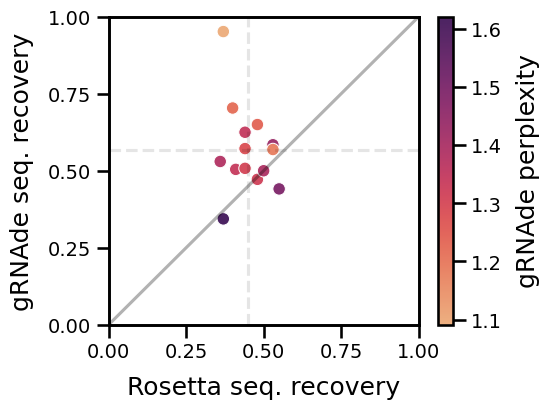

In [6]:
# Plot native sequence recovery per sample for Rosetta vs. gRNAde, shaded by gRNAde’s average perplexity for each sample
plt.figure(figsize=(5, 4))

plt.plot([0, 1], [0, 1], transform=plt.gca().transAxes, ls="-", c="black", alpha=0.3)

stat = df_sample.groupby("model_name").mean()
rosetta_stat = stat.loc["Rosetta"]["mean_recovery"]
grnade_stat = stat.loc["gRNAde"]["mean_recovery"]
plt.plot([rosetta_stat, rosetta_stat], [0, 1], transform=plt.gca().transAxes, ls="--", c="black", alpha=0.1)
plt.plot([0, 1], [grnade_stat, grnade_stat], transform=plt.gca().transAxes, ls="--", c="black", alpha=0.1)

ax = sns.scatterplot(
    data = df,
    x = "rosetta_recovery", y = "grnade_recovery",
    hue = "grnade_perplexity", palette="flare",
    alpha=1.0,
)
# set model names as x and y axis labels
plt.xlabel("Rosetta seq. recovery", labelpad=10)
plt.ylabel("gRNAde seq. recovery", labelpad=10)
# set x and y axis range to 0-1
plt.xticks(np.arange(0, 1.01, 0.25), fontsize=14) # plt.xlim(0, 1)
plt.yticks(np.arange(0, 1.01, 0.25), fontsize=14) # plt.ylim(0, 1)
# Add perplexity colorbar
norm = plt.Normalize(df['grnade_perplexity'].min(), df['grnade_perplexity'].max())
sm = plt.cm.ScalarMappable(cmap="flare", norm=norm)
sm.set_array([])
# Remove the legend and add a colorbar
ax.get_legend().remove()
cbar = plt.colorbar(sm, ax=ax)
cbar.ax.tick_params(labelsize=14)
ax2 = ax.twinx()
ax2.set_ylabel("gRNAde perplexity", labelpad=70)
ax2.set_yticks([])
plt.savefig(os.path.join(PROJECT_PATH, "tutorial/outputs/singlestate-scatterplot.pdf"), dpi=300, bbox_inches="tight")
plt.show()

---

### Multi-state inverse folding

[Riboswitches](https://pdb101.rcsb.org/motm/130) are flexible RNA molecules that adopt more than one distinct functional conformation, for instance a ligand bound (holo) and unbound (apo) state, which helps them regulate and control gene expression.
Structural studies of an adenine riboswitch have found distinct structures for two unbound apo structures, one ligand-bound intermediate, and a final ligand-bound conformation [24].

If we were to attempt single-state inverse design for the adenine riboswitch, each structure may lead to a different set of sampled sequences for which recovery and self-consistency may vary widely.
Thus, it is interesting to consider a design setting where we perform fixed-backbone re-design from multiple adenine riboswitch conformations.

![](fig/adenine_riboswitch.png)

The `design_from_directory()` function in the gRNAde module performs fixed-backbone re-design from a set of PDB files/RNA structures corresponding to the same RNA molecule, and optionally saves the designed sequences to a fasta file.
The workflow is as follows:

1. Instantiate a new multi-state variant of the gRNAde module by setting an appropriate `max_num_conformers` (in this example, we set it to 3 states).

2. Prepare a directory containing PDB files for multi-state fixed-backbone re-design. For instance, we will use multiple conformations of the adenine riboswitch (PDB IDs: [5E54](https://www.rcsb.org/structure/5E54), [5SWD](https://www.rcsb.org/structure/5SWD) and [5SWE](https://www.rcsb.org/structure/5SWE)) which are stored in the directory `/tutorial/demo_data/adenine_riboswitch/`. Note that each PDB file must contain only one chain and all RNA backbone atoms, corresponding to the same native RNA sequence.

3. Specify an output filepath pointing to a fasta file where the designed sequences, corresponding evaluation metrics, and additional metadata will be saved. We will set this to `/tutorial/demo_output_multistate.fasta`.

4. Set the configurations for the model's sampling process: `n_samples`, `temperature` and `seed`. 

5. Call the `design_from_directory()` function from the `grnade_module` instance using the specified input and output filepaths as well as sampling configurations.

6. Within seconds, the designed sequences will be saved to the fasta file `/tutorial/demo_output_multistate.fasta`.

<details>
<summary><b>Running via the command line</b></summary>

Alternatively to the workflow described above, we can also use the `gRNAde.py` script via command line arguments to achieve the same outcome, as follows:
```sh
python gRNAde.py \
    --directory_filepath tutorial/demo_data/adenine_riboswitch/ \
    --output_filepath tutorial/demo_output.fasta \
    --split das \
    --max_num_conformers 3 \
    --n_samples 16 \
    --temperature 0.5
```

</details>

In [7]:
# Create an instance of multi-state gRNAde
gRNAde_module = gRNAde(split='das', max_num_conformers=3, gpu_id=0)

# Multi-state design example usage
sequences, samples, perplexity, recovery_sample, sc_score = gRNAde_module.design_from_directory(
    directory_filepath = os.path.join(PROJECT_PATH, "tutorial/demo_data/adenine_riboswitch/"),
    output_filepath = os.path.join(PROJECT_PATH, "tutorial/outputs/demo_output_multistate.fasta"),
    n_samples = 16,
    temperature = 1.0,
    seed = 0
)
for seq in sequences:
    print(seq.format('fasta'))

Instantiating gRNAde v0.3
    Using device: cuda:0
    Creating RNA graph featurizer for max_num_conformers=3
    Initialising GNN encoder-decoder model
    Loading model checkpoint: /home/ckj24/rna-inverse-folding/checkpoints/gRNAde_ARv1_3state_das.h5
Finished initialising gRNAde v0.3

>input_sequence, gRNAde_version=0.3, model=AutoregressiveMultiGNNv1, max_num_conformers=3, checkpoint=/home/ckj24/rna-inverse-folding/checkpoints/gRNAde_ARv1_3state_das.h5, seed=0
GGGAAGAUAUAAUCCUAAUGAUAUGGUUUGGGAGUUUCUACCAAGAGCCUUAAACUCUUG
AUUAUCUU

>sample=0, seed=0, temperature=1.0, perplexity=1.7506, recovery=0.4706, edit_dist=32, sc_score=0.8490
UACAGGAGGUAAGCGUCCUAUUAUGGUGGGCGCAUCUUAGUGGACGCCCUUAAAGCGUCU
CUCCUCCU

>sample=1, seed=0, temperature=1.0, perplexity=1.3297, recovery=0.5441, edit_dist=31, sc_score=0.7772
AGAGACAGCUAAGCCUCUUGUUAUGGUAGGGGCGUUUAAGCGGACUCCCUUAAAGAGUCC
GUGCUGUC

>sample=2, seed=0, temperature=1.0, perplexity=1.5792, recovery=0.5294, edit_dist=31, sc_score=0.8430
GGGGUGAGUGUGG

## 🚀 Using gRNAde for custom RNA design scenarios
Check out the [Design notebook](https://github.com/chaitjo/geometric-rna-design/blob/main/notebooks/design.ipynb), which provides the following functionality:
- **Ready to use:** Full functional usage of pre-trained gRNAde models for fixed backbone re-design of RNA structures from your own PDB files.
- **Custom constraints:** Add your own design constraints, e.g. fixing key functional nucleotides, conditioning the remaining sequence on conserved nucleotides, biasing sampling.
- **Rank designs:** Evaluation and visualization tools for designed RNA sequences, including metrics for selecting amongst designs: sequence recovery, perplexity, 2D self-consistency score (EternaFold), 3D self-consistency scores (RhoFold), chemical modification self-consistency score (RibonanzaNet).

<a target="_blank" href="https://colab.research.google.com/drive/1ajcikLbM9v8_mYwWuZAcVP57nek6UBQD">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

---

## Notes on methodology

1. How to chose the number of states to provide as input to gRNAde? In general, this would depend on the design objective. For instance, designing a riboswitch may neccessitate multi-state design, while a single-state pipeline may be more sensible for locking an aptamer into its bound conformation [12]. Note that it may be possible to benefit from multi-state gRNAde models even when performing single-state design by using slightly noised variations of the same backbone structure as an input conformational ensemble.

2. How to prioritise or chose amongst designed sequences? We have currently provided 3 evaluation metrics: native sequence recovery, secondary structure self-consistency score and perplexity, towards this end. We suspect that recovery may not be the ideal choice, except for design scenarios where we require certain regions of the RNA to be conserved or native-like. Self-consistency score may be a more holistic evaluation metric as it accounts for alternative base pairings leading to similar structures, but may inherit the limitations of the secondary structure prediction method used as part of its computation. In realistic design scenarios, we can pair gRNAde with another machine learning model (an 'oracles') for ranking or predicting the suitability of designed sequences for the objective (for instance, binding affinity). We hope to conduct further experimental validation of gRANde designs in the wet lab in order to better understand these tradeoffs. 

3. Key limitation of gRNAde and avenues for future development include the lack of support for multiple interacting RNA chains, or accounting for biomolecular interactions of RNAs with proteins, small molecules, and other ligands. More advanced user configurations, such as only partial re-design of only prespecified nucleotides and negative design against undesired conformations are also not possible at the moment. 

4. The multi-state GNN architecture currently uses Geometric Vector Perceptron GNN layers [22] combined with Deep Set pooling [23]. Future iterations of gRNAde will consider using more expressive geometric GNN layers [25] as well as set pooling functions [26] for improved modelling of RNA 3D geometry and conformational diversity. 

---

## References

[1] Zhu, Y., Zhu, L., Wang, X., & Jin, H. (2022). RNA-based therapeutics: an overview and prospectus. Cell death & disease, 13(7), 644.

[2] Metkar, M., Pepin, C. S., & Moore, M. J. (2023). Tailor made: the art of therapeutic mRNA design. Nature Reviews Drug Discovery, 1-17.

[3] Doudna, J. A., & Charpentier, E. (2014). The new frontier of genome engineering with CRISPR-Cas9. Science, 346(6213), 1258096.

[4] Guo, P. (2010). The emerging field of RNA nanotechnology. Nature nanotechnology, 5(12), 833-842.

[5] Bronstein, M. M., Bruna, J., Cohen, T., & Veličković, P. (2021). Geometric deep learning: Grids, groups, graphs, geodesics, and gauges. arXiv preprint arXiv:2104.13478.

[6] Jumper, J., Evans, R., Pritzel, A., Green, T., Figurnov, M., Ronneberger, O., ... & Hassabis, D. (2021). Highly accurate protein structure prediction with AlphaFold. Nature, 596(7873), 583-589.

[7] Dauparas, J., Anishchenko, I., Bennett, N., Bai, H., Ragotte, R. J., Milles, L. F., ... & Baker, D. (2022). Robust deep learning–based protein sequence design using ProteinMPNN. Science, 378(6615), 49-56.

[8] Watson, J. L., Juergens, D., Bennett, N. R., Trippe, B. L., Yim, J., Eisenach, H. E., ... & Baker, D. (2023). De novo design of protein structure and function with RFdiffusion. Nature, 620(7976), 1089-1100.

[9] Das, R. (2021). RNA structure: a renaissance begins?. Nature Methods, 18(5), 439-439.

[10] Townshend, R. J., Eismann, S., Watkins, A. M., Rangan, R., Karelina, M., Das, R., & Dror, R. O. (2021). Geometric deep learning of RNA structure. Science, 373(6558), 1047-1051.

[11] Churkin, A., Retwitzer, M. D., Reinharz, V., Ponty, Y., Waldispühl, J., & Barash, D. (2018). Design of RNAs: comparing programs for inverse RNA folding. Briefings in bioinformatics, 19(2), 350-358.

[12] Yesselman, J. D., Eiler, D., Carlson, E. D., Gotrik, M. R., d’Aquino, A. E., Ooms, A. N., ... & Das, R. (2019). Computational design of three-dimensional RNA structure and function. Nature nanotechnology, 14(9), 866-873.

[13] Ganser, L. R., Kelly, M. L., Herschlag, D., & Al-Hashimi, H. M. (2019). The roles of structural dynamics in the cellular functions of RNAs. Nature reviews Molecular cell biology, 20(8), 474-489.

[14] Hoetzel, J., & Suess, B. (2022). Structural changes in aptamers are essential for synthetic riboswitch engineering. Journal of Molecular Biology, 167631.

[15] Ken, M. L., Roy, R., Geng, A., Ganser, L. R., Manghrani, A., Cullen, B. R., ... & Al-Hashimi, H. M. (2023). RNA conformational propensities determine cellular activity. Nature, 1-7.

[16] Adamczyk, B., Antczak, M., & Szachniuk, M. (2022). RNAsolo: a repository of cleaned PDB-derived RNA 3D structures. Bioinformatics, 38(14), 3668-3670.

[17] Leman, J. K., Weitzner, B. D., Lewis, S. M., Adolf-Bryfogle, J., Alam, N., Alford, R. F., ... & Bonneau, R. (2020). Macromolecular modeling and design in Rosetta: recent methods and frameworks. Nature methods, 17(7), 665-680.

[18] Das, R., Karanicolas, J., & Baker, D. (2010). Atomic accuracy in predicting and designing noncanonical RNA structure. Nature methods, 7(4), 291-294.

[19] Dawson, W. K., Maciejczyk, M., Jankowska, E. J., & Bujnicki, J. M. (2016). Coarse-grained modeling of RNA 3D structure. Methods, 103, 138-156.

[20] Wadley, L. M., Keating, K. S., Duarte, C. M., & Pyle, A. M. (2007). Evaluating and learning from RNA pseudotorsional space: quantitative validation of a reduced representation for RNA structure. Journal of molecular biology, 372(4), 942-957.

[21] Ingraham, J., Garg, V., Barzilay, R., & Jaakkola, T. (2019). Generative models for graph-based protein design. Advances in neural information processing systems, 32.

[22] Jing, B., Eismann, S., Suriana, P., Townshend, R. J. L., & Dror, R. (2020, October). Learning from Protein Structure with Geometric Vector Perceptrons. In International Conference on Learning Representations.

[23] Zaheer, M., Kottur, S., Ravanbakhsh, S., Poczos, B., Salakhutdinov, R. R., & Smola, A. J. (2017). Deep sets. Advances in neural information processing systems, 30.

[24] Stagno, J. R., Liu, Y., Bhandari, Y. R., Conrad, C. E., Panja, S., Swain, M., ... & Wang, Y. X. (2017). Structures of riboswitch RNA reaction states by mix-and-inject XFEL serial crystallography. Nature, 541(7636), 242-246.

[25] Joshi, C.K., Bodnar, C., Mathis, S.V., Cohen, T. & Lio, P.. (2023). On the Expressive Power of Geometric Graph Neural Networks. Proceedings of the 40th International Conference on Machine Learning, in Proceedings of Machine Learning Research 202:15330-15355.

[26] Maron, H., Litany, O., Chechik, G. & Fetaya, E.. (2020). On Learning Sets of Symmetric Elements. Proceedings of the 37th International Conference on Machine Learning, in Proceedings of Machine Learning Research 119:6734-6744.
